In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import glob
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

In [3]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [4]:
DATA_DIRS_LIST = glob.glob("../data/*")
DATA_DIRS_LIST

['../data/german_equity', '../data/dax-euro', '../data/simulated']

In [5]:
glob.glob(os.path.join(DATA_DIRS_LIST[0], "*"))

['../data/german_equity/xFGBS',
 '../data/german_equity/xFGBM',
 '../data/german_equity/xFGBL',
 '../data/german_equity/README']

In [6]:
glob.glob(os.path.join(DATA_DIRS_LIST[1], "*"))

['../data/dax-euro/xFSXE', '../data/dax-euro/README', '../data/dax-euro/xFDAX']

## Low-tick asset: DAX

Side:
* $-1$: ask
* $1$: bid

Type:
* $-1$: limit
* $0$: cancel
* $1$: trade

In [7]:
DAX_DATA_PATH = "../data/dax-euro/xFDAX"
DAX_DATA_LIST = glob.glob(os.path.join(DAX_DATA_PATH, "*"))
DAX_DATA_LIST.sort()

In [8]:
df = pd.read_csv(DAX_DATA_LIST[0])

df

,Date,Time,Volume,OrderType,Side,AskPriceAfter,AskQtyAfter,AskSplitAfter,BidPriceAfter,BidQtyAfter,BidSplitAfter
0,20130701,28806.446250,13,1,1,7956.0,1,1,7955.5,30,2
1,20130701,28806.584304,4,1,1,7956.0,1,1,7955.5,34,3
2,20130701,28806.601666,1,0,-1,7957.0,5,2,7955.5,34,3
3,20130701,28806.603896,4,1,1,7957.0,5,2,7955.5,38,4
4,20130701,28806.752690,1,1,1,7957.0,5,2,7956.5,1,1
5,20130701,28806.891006,1,1,-1,7957.0,6,3,7956.5,1,1
6,20130701,28806.892582,1,1,-1,7957.0,7,4,7956.5,1,1
7,20130701,28807.066006,1,1,1,7957.0,7,4,7956.5,2,2
8,20130701,28807.096734,1,0,-1,7957.0,6,3,7956.5,2,2
9,20130701,28807.097236,3,0,-1,7957.0,3,3,7956.5,2,2


# Influence of limit and trades

In [9]:
from torch import nn

from models import HawkesDecayRNN
from train_functions import train_decayrnn

In [10]:
# Remove cancel orders from the dataset
df = df[df.OrderType != 0]

In [11]:
evt_times = df.Time.values
evt_types = (df.OrderType.values + 1)//2

In [12]:
day_stamp = df.Date.unique()[0]
print(day_stamp)

20130701


In [13]:
split_times_list = np.array_split(evt_times, 1000)
split_types_list = np.array_split(evt_types, 1000)
seq_lengths = [len(e) for e in split_times_list]

seq_lengths = torch.LongTensor(seq_lengths) - 1

split_times_list = [torch.from_numpy(e) for e in split_times_list]
split_types_list = [torch.from_numpy(e) for e in split_types_list]

In [14]:
seq_times = nn.utils.rnn.pad_sequence(split_times_list, batch_first=True).to(torch.float32)
seq_types = nn.utils.rnn.pad_sequence(split_types_list, batch_first=True, padding_value=2)

In [15]:
process_dim = 2
hidden_size = 128

In [16]:
model = HawkesDecayRNN(process_dim, hidden_size)

In [17]:
MODEL_FILES = glob.glob("../saved_models/HawkesDecay*")
MODEL_FILES.sort(reverse=True)
MODEL_FILES

['../saved_models/HawkesDecayRNN-2d_hidden128-20181210-020901.pth',
 '../saved_models/HawkesDecayRNN-2d_hidden128-20181210-013110.pth',
 '../saved_models/HawkesDecayRNN-2d_hidden128-20181209-212603.pth',
 '../saved_models/HawkesDecayRNN-2d_hidden128-20181209-153942.pth']

In [18]:
model.load_state_dict(torch.load(MODEL_FILES[0], map_location={"cuda:0": "cpu"}))

# Evaluation

In [19]:
from utils import evaluation

In [20]:
dataset_size = seq_times.shape[0]
print("Dataset size:", dataset_size)

Dataset size: 1000


last event: time 36941.938 type 0.000
next event: time 36941.938 type 1.000, in 0.000
sum of density: tensor(0.9491)
type probabilities: tensor([0.4463, 0.4953])


((tensor(0.0703), tensor(0.), tensor(0.0049), tensor(1), tensor(1)),
 <Figure size 1000x400 with 2 Axes>)

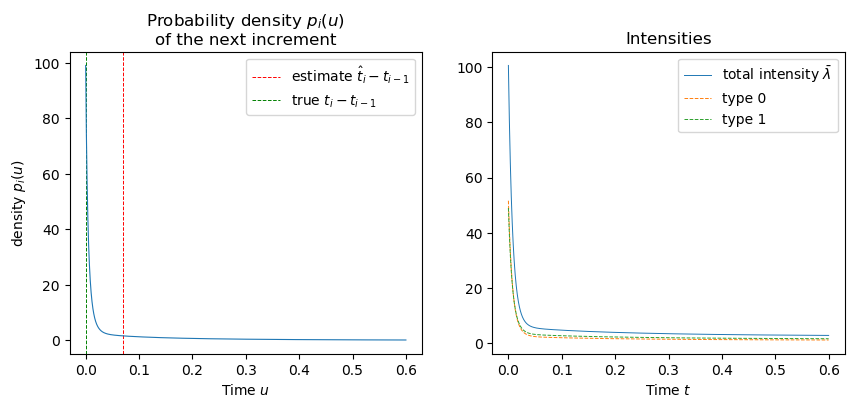

In [21]:
index_ = torch.randint(0, dataset_size, (1,)).int().item()

model.read_predict(seq_times[index_], seq_types[index_], seq_lengths[index_],
                   hmax=0.6, n_samples=4000, plot=True, print_info=True)

In [22]:
test_size = dataset_size

In [23]:
test_data = (seq_times, seq_types, seq_lengths)

In [24]:
incr_estimates, incr_errors, types_real, types_estimates = evaluation.predict_test(
    model, *test_data,
    hmax=0.7, use_jupyter=True)

In [28]:
avg_rmse = np.sqrt(np.mean(incr_errors), dtype=np.float64)
print("rmse", avg_rmse)

mse_var = np.var(incr_errors, dtype=np.float64)
print("mse var", mse_var)

delta_meth_stderr = np.sqrt(1 / test_size * mse_var / (4 * avg_rmse))
print("rmse var", delta_meth_stderr)

rmse 0.4078447146498932
mse var 3.8701783609364204
rmse var 0.04870662925495856


In [32]:
seq_times.shape

torch.Size([1000, 453])

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [30]:
types_predict_score = accuracy_score(types_real, types_estimates)
print("Type prediction score:", types_predict_score)

print("Confusion matrix:\n", confusion_matrix(types_real, types_estimates))

Type prediction score: 0.519
Confusion matrix:
 [[  0 481]
 [  0 519]]


## Sequence generation

In [65]:
from models.decayrnn import HawkesRNNGen

In [66]:
generator = HawkesRNNGen(model, record_intensity=False)

Process model dim:	2	Hidden units:	128


no. of events: 62
0: type 0
1: type 1


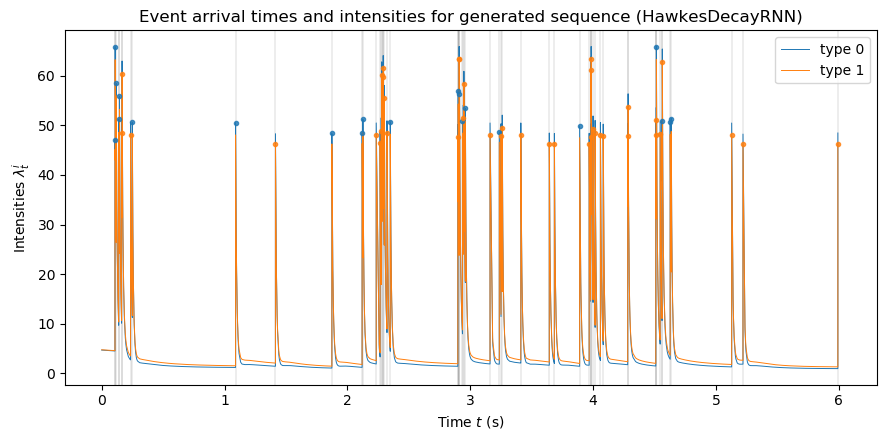

In [115]:
generator.generate_sequence(6, record_intensity=True)

_ = generator.plot_events_and_intensity()

Modèle de prix:
$$
    P_t = N_t^1 - N_t^2
$$

In [116]:
t_vals = np.linspace(0, 6.0)

In [117]:
def price(t):
    x = np.asarray(generator.event_times[1:]) <= t
    evt_types = np.asarray(generator.event_types[1:])
    print(x.shape)
    typ0 = x[:, evt_types == 0]
    typ1 = x[:, evt_types == 1]
    nt = np.sum(x, axis=1)
    nt1 = np.sum(typ0, axis=1)
    nt2 = np.sum(typ1, axis=1)
    return nt, nt1, nt2

(50, 61)


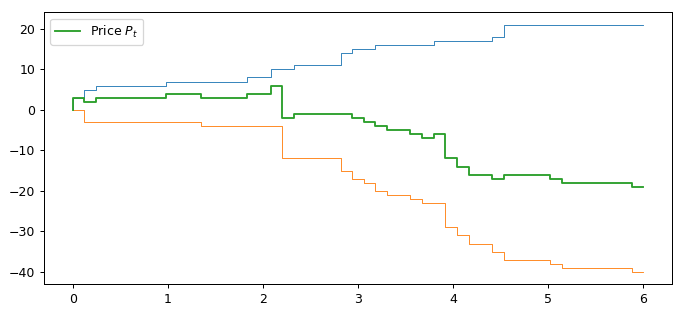

In [118]:
nt, nta, ntb = price(t_vals[:, None])
plt.figure(figsize=(9,4), dpi=90)
step_opts = dict(
    linewidth=.7)
plt.step(t_vals, nta, **step_opts)
plt.step(t_vals, -ntb, **step_opts)
pt = nta - ntb
plt.step(t_vals, pt, label="Price $P_t$")
plt.legend()